# Clustering

## Intro to Clustering

#### Clustering for Image Segmentation

Clustering is a powerful technique for grouping similar data points, and its effectiveness depends on the structure and preparation of the data. Below are the general requirements, data preparation steps, and specific considerations for various clustering methods.

---

#### General Requirements for Clustering

1. **Feature Representation**:
   - Data should be represented as a set of **features**. For images, this could be:
     - Pixel intensities or colors (e.g., RGB, LAB).
     - Derived metrics (e.g., vegetation indices, gradients, texture features).
     - Spatial information (e.g., coordinates of pixels).

2. **Dimensionality**:
   - Clustering operates on **n-dimensional feature vectors**. For image segmentation:
     - For color clustering: A 3D vector like `[R, G, B]` per pixel.
     - For spatial clustering: Combine color/intensity with spatial coordinates `[R, G, B, x, y]`.

3. **Normalization**:
   - Features should be scaled to the same range (e.g., [0, 1] or standardization) to prevent bias toward features with larger ranges.

4. **Separation of Clusters**:
   - Clustering is effective if there is a natural separation or structure in the data. Highly overlapping or noisy data can make clustering less reliable.

5. **Number of Clusters**:
   - Some clustering algorithms require you to specify the number of clusters (e.g., K-means), while others (e.g., DBSCAN) detect clusters based on density.

---

#### Data Preparation for Clustering

**1. Reshape Data**

For images, pixels need to be flattened into a 2D array where each row is a feature vector.

```python
# Reshape image into feature vectors
data = image.reshape(-1, image.shape[-1])  # (num_pixels, num_features)
```

**2. Combine Features**

If you want to use spatial information, add pixel coordinates as features.

```python
# Add spatial coordinates
h, w, c = image.shape
coords = np.indices((h, w)).reshape(2, -1).T  # (num_pixels, 2)
data_with_coords = np.hstack([data, coords])  # Combine image features with coordinates
```

**3. Normalize Features**

Normalize or scale features to ensure fair weighting.

```python
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
normalized_data = scaler.fit_transform(data_with_coords)
```


#### Key Considerations for Effectiveness

1. **Cluster Separability**:
   - Clustering performs best when clusters are well-separated.
   - Use dimensionality reduction (e.g., PCA, t-SNE) for visualization or feature extraction.

2. **Noise and Outliers**:
   - High noise levels can degrade clustering quality.
   - Use preprocessing (e.g., filtering) to clean the data.

3. **Feature Selection**:
   - Select meaningful features to improve clustering accuracy.
   - For images, consider combining color, texture, and spatial features.

## Notebook Setup

In [ ]:
# For website deployed environment
%pip install -q ipywidgets

In [2]:
# Load required libraries
import numpy as np
import cv2
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from skimage.color import rgb2lab
from scipy.ndimage import gaussian_filter, label
from PIL import Image
from ipywidgets import interact, FloatSlider, IntSlider
import sys
from pathlib import Path

# Add the parent directory to the Python path
sys.path.append(str(Path.cwd().parent))

%matplotlib inline

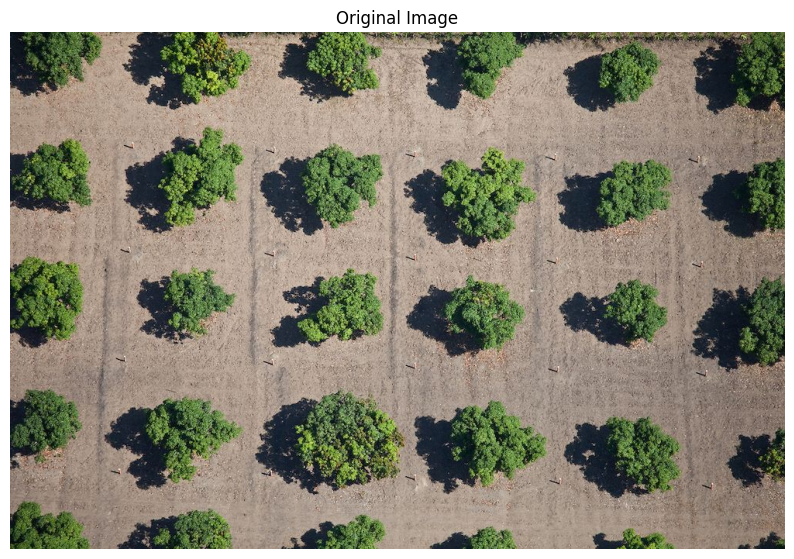

In [3]:
from plant_search.load_image import load_image, plot_image

# file_path = '../input/ESPG-4326-orthophoto.tif'
# file_path = '../input/MADRID_RGB.tif'
file_path = '../input/aerial-trees.jpg'

image = load_image(file_path)
if image is not None:
    plot_image(image, "Original Image")


In [4]:
from plant_search.vegetation_indices import calculate_all_rgb_indices


# Remember these guys from chapter 2? 
# We are going to see how they fare against clustering.
indices = calculate_all_rgb_indices(image)

## K-Means Clustering

This guy is our go-to. Super fast, mostly works. You are generally going to want to try this first if you need to do some clustering. 

One of the major downsides is that it makes you determine the number of clusters you are going to find *before* you run it. There are some ways around this (elbow technique), but it is a big limitation.

> From ChatGPT: 
- **Input**: Numeric data; requires the number of clusters (k) as an input.
- **Effectiveness**:
    - Works well when clusters are spherical and evenly distributed.
    - Sensitive to feature scaling (normalization is crucial).
- **Limitations**:
    - Struggles with irregularly shaped clusters or clusters of different sizes.

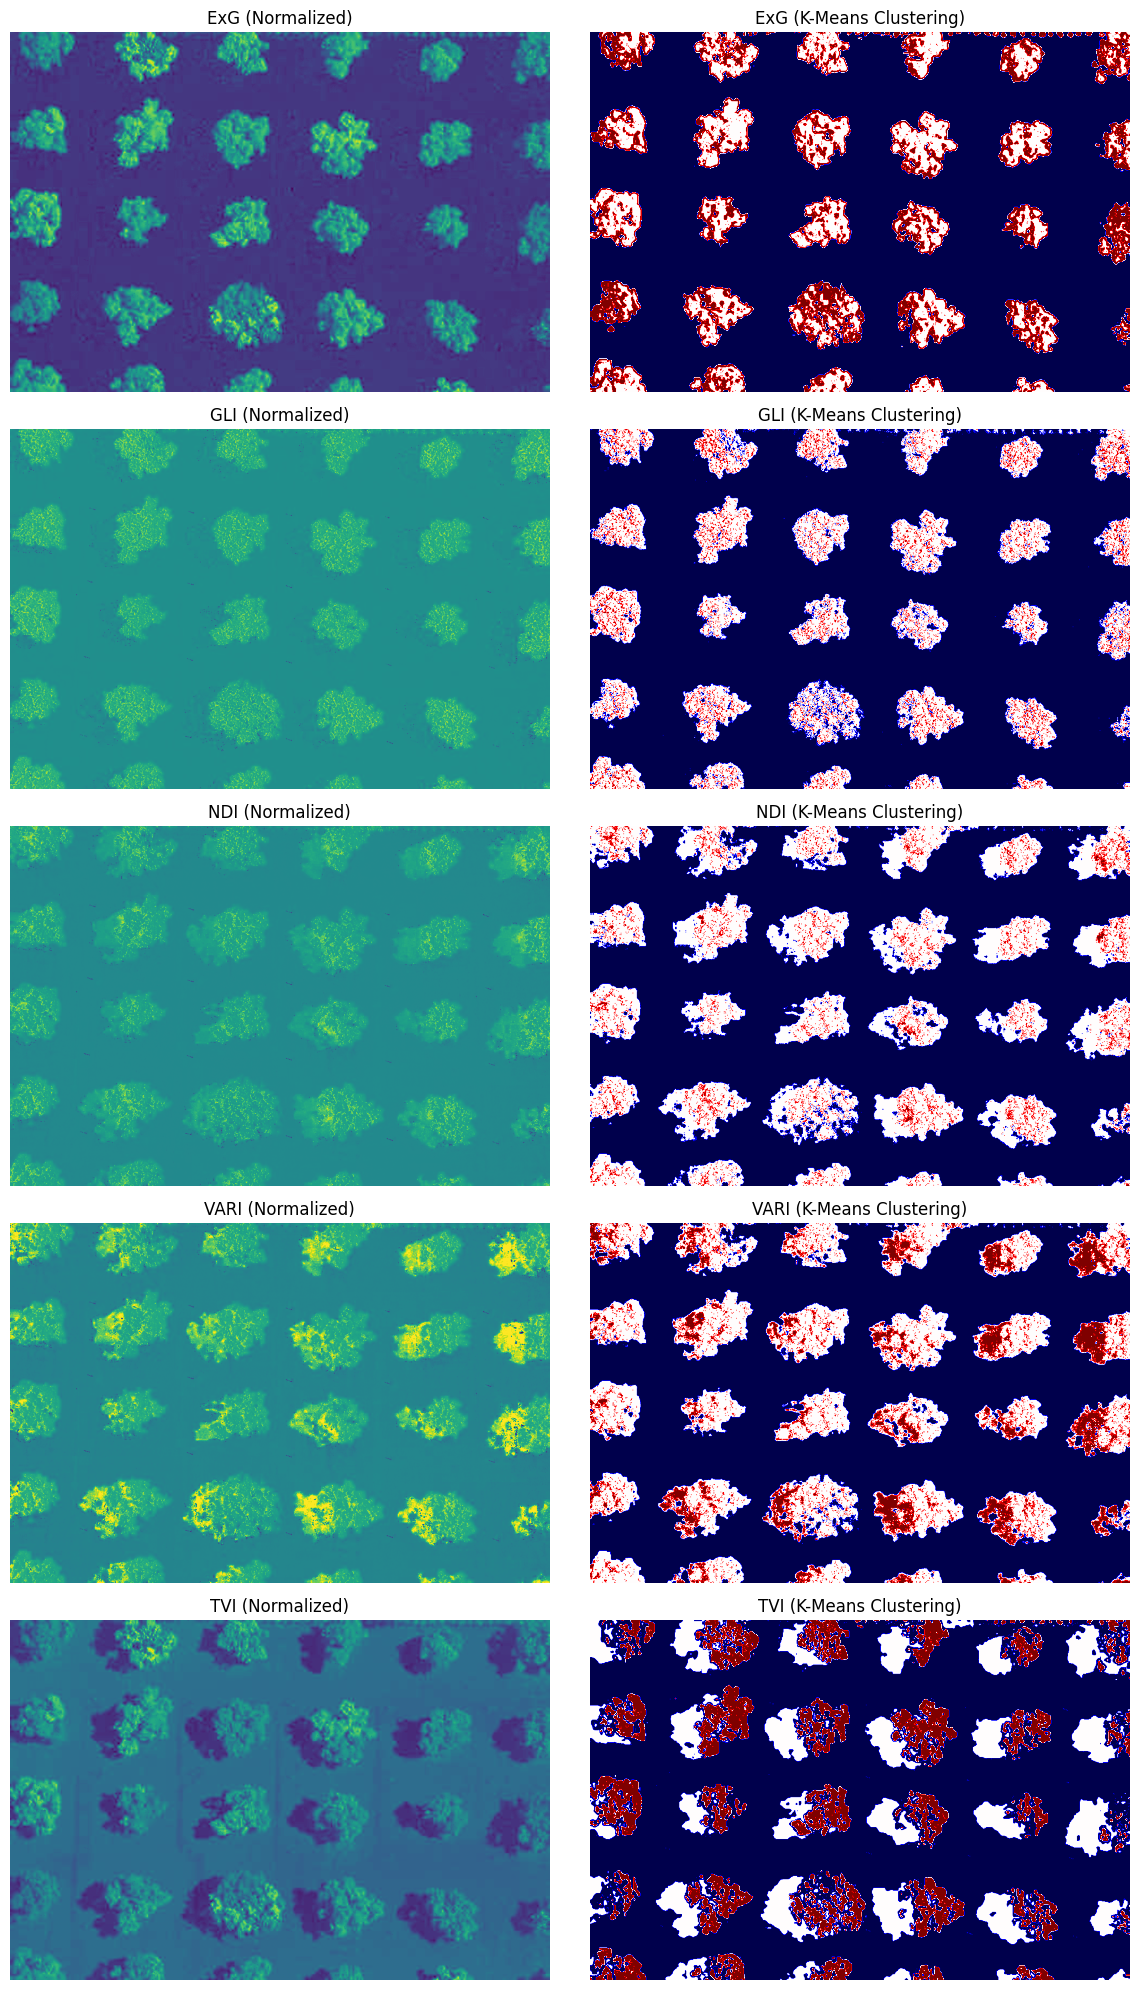

In [5]:
from sklearn.cluster import KMeans


# Reshape image or vegetation index for clustering
def prepare_data_for_clustering(image, use_index=None):
    """
    Prepare data for clustering.

    Parameters:
    - image: RGB image (H, W, 3).
    - use_index: Vegetation index to use for clustering (e.g., "ExG", "GLI", None for RGB).

    Returns:
    - reshaped_data: Data reshaped to (N, features) for clustering.
    - original_shape: Shape of the original image.
    """
    if use_index is None:
        # Use RGB values for clustering
        reshaped_data = image.reshape(-1, 3)
    else:
        # Use vegetation index
        index_data = indices[use_index]
        reshaped_data = index_data.flatten().reshape(-1, 1)  # Single feature (index)
    return reshaped_data, image.shape[:2]

# Apply k-means clustering
def apply_kmeans_clustering(data, n_clusters=3):
    """
    Apply k-means clustering to the prepared data.

    Parameters:
    - data: Data prepared for clustering (N, features).
    - n_clusters: Number of clusters.

    Returns:
    - Cluster labels for each data point.
    """
    h, w = data.shape
    data = data.reshape(-1, 1)  # Reshape for K-Means
    kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(data)
    labels = kmeans.labels_.reshape(h, w)  # Reshape back to the image
    return labels


# Plot vegetation indices and their K-Means cluster maps
fig, axes = plt.subplots(len(indices), 2, figsize=(12, 4 * len(indices)))

for i, (key, index) in enumerate(indices.items()):
    # K-Means clustering
    clustered = apply_kmeans_clustering(index, 3)

    # Vegetation index plot
    axes[i, 0].imshow(index, cmap="viridis")
    axes[i, 0].set_title(f"{key} (Normalized)")
    axes[i, 0].axis("off")

    # K-Means clustering plot
    axes[i, 1].imshow(clustered, cmap="seismic")
    axes[i, 1].set_title(f"{key} (K-Means Clustering)")
    axes[i, 1].axis("off")

plt.tight_layout()
plt.show()


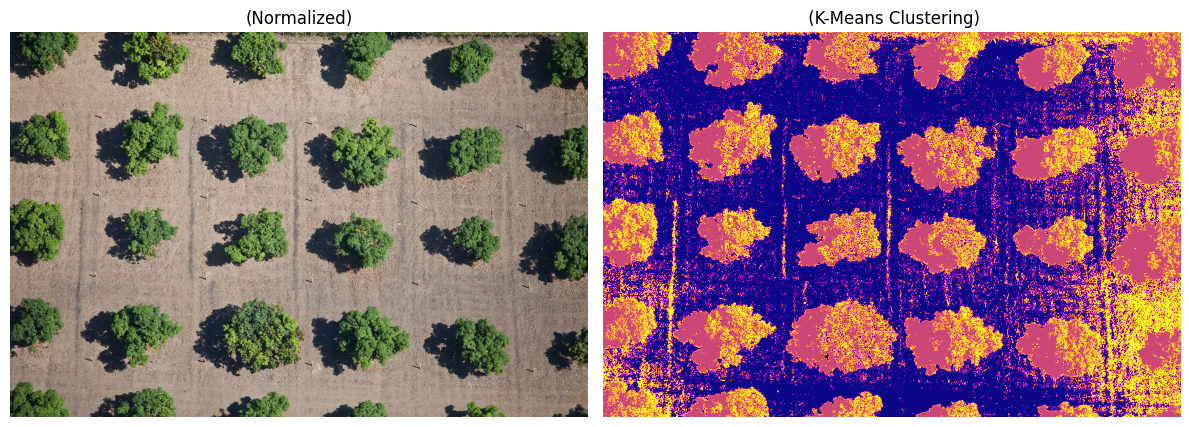

In [ ]:
data = image.reshape(-1, 3)
kmeans = KMeans(n_clusters=3, random_state=42).fit(data)
cluster_labels = kmeans.fit_predict(data)
clustered_image = cluster_labels.reshape(image.shape[:2])

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
# Vegetation index plot
axes[0].imshow(image)
axes[0].set_title(f"Original Image")
axes[0].axis("off")

# K-Means clustering plot
axes[1].imshow(clustered_image, cmap="plasma")
axes[1].set_title(f"RGB K-Means Clustering")
axes[1].axis("off")

plt.tight_layout()
plt.show()

In [ ]:
from ipywidgets import interact, IntSlider

def interactive_clustering(n_clusters):
    cluster_labels = apply_kmeans_clustering(data, n_clusters=n_clusters)
    visualize_clusters(cluster_labels, original_shape, title=f"Clustering with {n_clusters} Clusters")

interact(interactive_clustering, n_clusters=IntSlider(value=3, min=2, max=10, step=1, description="Clusters"))


interactive(children=(IntSlider(value=3, description='Clusters', max=10, min=2), Output()), _dom_classes=('wid…

<function __main__.interactive_clustering(n_clusters)>

#### Gaussian Mixture Models (GMM)

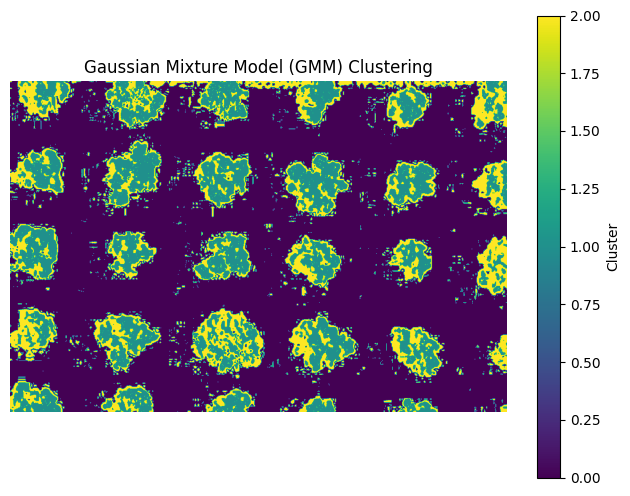

In [ ]:
from sklearn.mixture import GaussianMixture

# Apply Gaussian Mixture Model
def apply_gmm_clustering(data, n_components=3):
    """
    Apply Gaussian Mixture Model (GMM) clustering.

    Parameters:
    - data: Data prepared for clustering (N, features).
    - n_components: Number of Gaussian components (clusters).

    Returns:
    - Cluster labels for each data point.
    """
    gmm = GaussianMixture(n_components=n_components, random_state=42)
    labels = gmm.fit_predict(data)
    return labels

# Example: Use ExG for GMM clustering
data, original_shape = prepare_data_for_clustering(image, use_index="ExG")
gmm_labels = apply_gmm_clustering(data, n_components=3)
visualize_clusters(gmm_labels, original_shape, title="Gaussian Mixture Model (GMM) Clustering")


#### DBSCAN (Density-Based Spatial Clustering)

DO NOT RUN THIS FOR ANY REASON

COMPLETELY EATS YOUR RAM

WELCOME TO SWAP SPACE

In [ ]:
from sklearn.cluster import DBSCAN

# Apply DBSCAN Clustering
def apply_dbscan_clustering(data, eps=0.05, min_samples=10):
    """
    Apply DBSCAN clustering.

    Parameters:
    - data: Data prepared for clustering (N, features).
    - eps: Maximum distance between two samples for them to be considered as neighbors.
    - min_samples: Minimum number of points in a neighborhood to form a cluster.

    Returns:
    - Cluster labels for each data point.
    """
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    labels = dbscan.fit_predict(data)
    return labels

# Example: Use ExG for DBSCAN clustering
# data, original_shape = prepare_data_for_clustering(image, use_index="ExG")
# dbscan_labels = apply_dbscan_clustering(data, eps=0.12, min_samples=5)
# visualize_clusters(dbscan_labels, original_shape, title="DBSCAN Clustering")
